# Plotting With Gadfly in ≤ 15 Minutes
Jason A. Grafft

jason@grafft.co

1. Introduction
2. `@>> ["Julia", "Gadfly"] map(x -> "Why $x?")`
3. DataFrame-type structures
4. Plotting with Gadfly
5. Resources

## 1. Introduction

In [15]:
# Library for lazy loading
using Lazy

# Libraries for data handling
using DataFrames, Loess, Query

# Library-in-question
using Gadfly

# Helper functions for generating and plotting data
plus001(n::Float64) = @lazy n+0.001:plus001(n+0.001);
epoch_ll = @> 1530426514. plus001;

df_ll(n::Int64) = @lazy DataFrame(t=[x for x in take(n, epoch_ll)], x=rand(n), y=rand(n), z=rand(n)):df_ll(n);

xyzColors = [(:x, colorant"deepskyblue"), (:y, colorant"orange"), (:z, colorant"green")]

sensorXYZ(d::DataFrame) = @>> xyzColors map(s -> plot(d, x=:t, y=s[1], color=[s[2]], Guide.xticks(label=false), Guide.ylabel("$(s[1])"), Geom.smooth)) hstack
sensorXYZnl(d::DataFrame) = @>> xyzColors map(s -> plot(d, x=:t, y=s[1], color=[s[2]], Guide.xlabel(""), Guide.xticks(label=false), Guide.ylabel(""), Guide.yticks(label=false), Geom.smooth)) hstack
sensorXYZsc(d::DataFrame) = @>> xyzColors map(s -> plot(d, x=:t, y=s[1], color=[s[2]], Guide.xlabel(""), Guide.xticks(label=false), Guide.ylabel(""), Guide.yticks(ticks=[0.465,0.495,0.525]), Geom.smooth)) hstack
sensorXYZhl(d::DataFrame) = @>> xyzColors map(s -> hlPlot(d[:t], d[s[1]], s[2])) hstack

mapL(f::Function, l::Lazy.LazyList) = @>> l map(x -> @>> x map(y -> @> y head(5000) f))
mapR(f::Function, l::Lazy.LazyList) = @>> l map(x -> @> x head(5000)) map(x -> @> x f)

_layer(t) = layer(x=:t, y=t[1], color=[t[2]], Geom.smooth)

themedPlot(d::DataFrame) = plot(d, _layer((:x, colorant"deepskyblue")), _layer((:y, colorant"orange")), _layer((:z, colorant"green")), Guide.ylabel(""), Guide.manual_color_key("Column", ["x", "y", "z"], ["deepskyblue", "orange", "green"]))
themedPlotNL(d::DataFrame) = plot(d, _layer((:x, colorant"deepskyblue")), _layer((:y, colorant"orange")), _layer((:z, colorant"green")), Guide.xlabel(""), Guide.xticks(label=false), Guide.ylabel(""), Guide.yticks(label=false), Guide.manual_color_key("Column", ["x", "y", "z"], ["deepskyblue", "orange", "green"]))

function hlPlot(a, b, c::ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}})
    model = @> a loess(b)
    us = @> minimum(a):0.1:maximum(a) collect
    vs = @> model predict(us)
    d = DataFrame(us=us, vs=vs)
    
    lt = @from i in d begin
        @where i.vs < 0.495
        @select i
        @collect DataFrame 
    end
    
    plot(
        layer(lt, x=:us, y=:vs, Geom.line, Theme(default_color=colorant"red", line_width=0.5mm)),
        layer(d, x=:us, y=:vs, Geom.line, Theme(default_color=c)),
        Guide.xlabel(""),
        Guide.xticks(label=false),
        Guide.ylabel("")
#         , Guide.yticks(label=false, ticks=[0.465,0.495,0.525])
    )
end

hlPlot (generic function with 1 method)

## 2. `@>> ["Julia", "Gadfly"] map(x -> "Why $x?")`
1. Julia
    - Python/R inspired syntax
    - Exceptionally performant
    - Purpose-built for numerical computing
    - Friendly to algebraic structures, functional programming
2. Gadfly
    - Built on Julia
    - SVG drawing package
    - Friendly to \*\*flow programming patterns

## 3. DataFrame-type structures
DataFrame-type structures are familiar. They are ignorantly opinionated, and we love them for it.

In [ ]:
n = 12;
DataFrame(t=[x for x in take(n, epoch_ll)], x=rand(n), y=rand(n), z=rand(n))

Relationships in the physical world are not strictly 2-dimensional, however. "In the wild", there is a function which polls each sensor in a set and translates $SensorData$ to a $DataFrame$, then stores each DataFrame in a list. Formally, we have

$$f: SensorData \rightarrow DataFrame$$
$$map: [SensorData] \rightarrow f \rightarrow [DataFrame]$$ where
$$\{\ell, L, [*]\} \in List$$
$$\{f, map\} \in Function$$
$$\forall\ell\in L: \ell\ni DataFrame$$

Here, we use nesting to partially encode the data. This provides critical context (state) to the functions tasked to process it.

In our current case, each set of sensors, $\ell$, provides a master control system with a partial view of the surrounding environment. Compressing $\ell$ into a single value (object) prior to reporting upward allows the control system to more efficiently reason.

In [2]:
# Lazy list of "sensor" data where each inner list is of length `n` and each DataFrame has 'l' entries.
sensorArray(n::Int, l::Int) = @lazy take(n, df_ll(l)):sensorArray(n, l);

# Lazy list of six (6) lists of length five (5), with each DataFrame
# holding 15,323 entries--approximately 15 seconds at 1000hz.
rawSensorData = @>> sensorArray(5, 15323) take(6);

## 4. Plotting with Gadfly
- Standard plots readily available
    - [GitHub Gallery](https://github.com/GiovineItalia/Gadfly.jl#gallery)
    - [Gadfly.Geometries](http://gadflyjl.org/stable/lib/geometries.html)
- Programmatic composition allows for arbitrary interleaving of logic
    - No need to coerce data into fixed structures or relations
    - Control of mutation, edge cases, missing values, ... in data
    - Data structuring schemas are highly visible (open source)
- Plots are values (objects)
    - Custom titles/axes/file names/...
    - Multiple computations/settings/data sets/...
    - "Low overhead" modifications
    - Layering and stacking
- Draws to SVG, SVGJS
    - PNG, PDF, and PS via Cairo backend
- Jupyter and REPL

In [ ]:
# Plot with largely default values
s35 = head(rawSensorData[3][5],5000)
plot(s35,
        x=:t,
        y=Col.value(:x, :y, :z),
        color=Col.index(:x, :y, :z),
        Guide.ylabel(""),
        Geom.smooth
    )

In [ ]:
# Custom colors
themedPlot(s35)

In [ ]:
# No labels
themedPlotNL(s35)

In [ ]:
# Data above with (x, y, z) plotted separately
@>> [:x, :y, :z] map(s -> plot(s35, x=:t, y=s, Guide.xticks(label=false), Guide.ylabel(""), Geom.smooth)) hstack

In [ ]:
# Custom colors
@> sensorXYZ(s35)

In [ ]:
# No labels
@> sensorXYZnl(s35)

In [ ]:
# Scaled
@> sensorXYZsc(s35)

Up to now we've been using the same DataFrame, `s35`. We want to apply these schemes to each DataFrame in our List. We will use a function which maps over $L$ and converts each `DataFrame` in each $\ell$ to a `Gadfly.Plot` object. Formally,

$$g: L \rightarrow P$$ where
$$g \in Function$$
$$\{\ell, P\} \in List$$
$$\forall\ell\in P: \ell\ni Gadfly.Plot$$

In [ ]:
# Apply `themedPlot` (add some color)
P = @>> rawSensorData mapL(themedPlot)
@> [themedPlot(s35), P[3][5]] hstack

In [ ]:
# Apply `themedPlotNL` (drop labels)
P_ = @>> rawSensorData mapL(themedPlotNL);
@> [themedPlotNL(s35), P_[3][5]] hstack

In [ ]:
# Apply `sensorXYZ` (make a grid)
sXYZ = @>> rawSensorData[1] mapR(sensorXYZ);
vstack(sXYZ[1], sXYZ[2], sXYZ[3])

In [ ]:
# Apply `sensorXYZnl` (drop labels)
sNL = @>> rawSensorData[1] mapR(sensorXYZnl);
vstack(sNL[1], sNL[2], sNL[3])

In [ ]:
# Apply `sensorXYZsc` (keep y scale consistent)
sSC = @>> rawSensorData[1] mapR(sensorXYZsc);
vstack(sSC[1], sSC[2], sSC[3])

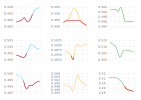

In [17]:
# Apply `sensorXYZhl` (highlights line segments < 0.495, no y-scaling)
sHL = @>> rawSensorData[1] mapR(sensorXYZhl);
vstack(sHL[1], sHL[2], sHL[3])#, sHL[4], sHL[5])

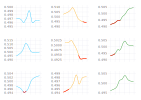

In [16]:
sHL = @>> rawSensorData[6] mapR(sensorXYZhl);
vstack(sHL[1], sHL[2], sHL[3])#, sHL[4], sHL[5])

## 5. Resources

- [Julia][jl]
    - [Julia Computing][jlc]
    - [JuliaBox][jbox]
- [Gadfly][gadfly]
- [DataFrames][df]
- [Jupyter][jup]
    - [DockerHub Jupyter Data Science Notebook][jup-ds]

[df]: http://juliadata.github.io/DataFrames.jl/stable/
[gadfly]: http://gadflyjl.org/stable/
[jbox]: http://juliabox.com/
[jl]: https://julialang.org/
[jlc]: https://juliacomputing.com/
[jup]: http://jupyter.org/
[jup-ds]: https://hub.docker.com/r/jupyter/datascience-notebook/